## Map ASV results to MAG relative abundance results
Find best fit ASV identity for each MAG

In [1]:
# Library loading
library(tidyverse); library(broom); library(ggtext)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
# Import list of ERR values with sampleIDs to link sample names between ASV and MAG data
err_joined <- read.delim("joined-ERRxxx-MAG-ASV.txt"); #head(err_joined)

# Import ASV taxonomy assignment results
load("tara-taxassign-30-06-2020.RData", verbose = T)

# Modify original ASV taxonomy from PR2 to be more similar to MAG taxa
## but include seq IDs to match with data
asv_tax <- tara_tax_df %>% 
    setNames(paste0("ASV_", names(.))) %>% 
    # Create original column to link back with original name schematic
    unite(ORIGINAL, starts_with("ASV_"), sep = ";", remove = FALSE)  %>%
    rownames_to_column(var = "seq") %>% 
    select(-ASV_Kingdom) %>% 
    # Replace taxname_XX with dashes, keep the first occurence when there is only 1 X
    mutate_at(vars(starts_with("ASV_")), funs(str_replace(., pattern = "(\\w+_XX+$|\\w+_XX+_sp.$)", replacement = "-"))) %>% 
    # Replace underscore with a space when not followed by an X
    mutate_at(vars(starts_with("ASV_")), funs(str_replace(., pattern = "_(?!X)", replacement = " "))) %>% 
    unite(fullname, starts_with("ASV_"), sep = ";", remove = FALSE, na.rm = TRUE) %>% 
    mutate_at(vars(fullname), funs(str_replace_all(., pattern = ";-", replacement = ""))) %>% 
    data.frame

# Import and format ASV results
tara <- readRDS("st.consensus.rds")

asv_relab <- as.data.frame(t(tara)) %>% # Transform
    rownames_to_column(var = "seq") %>% # Retrieve row names
    pivot_longer(cols = starts_with("ERR")) %>% # Convert to long format
    select(seq, ASV_run_accession = name, value) %>%
    left_join(asv_tax, by = "seq") %>% 
    # Calculate relative abundance (out of 100) # This matches the MAG format
    group_by(ASV_run_accession) %>% 
    mutate(RelAbun = 100*(value / sum(value))) %>% 
    select(-ORIGINAL, -value) %>%
    filter(RelAbun > 0) %>% 
    # Join by err match list, so sampleids match up to the ERR ids from ASV data
    left_join(select(err_joined, -MAG_run_accession)) %>% 
    # Modify column headers so they match the MAG-based data
    rename_all(. %>% tolower %>% gsub("asv_", "", .)) %>% 
    data.frame

# Import results from MAG-based taxonomic assignment
mag_tax <- read.delim("/vortexfs1/omics/alexander/shu/euk_mag_abund/high-euk.50cutoff.tab")

# Import results from MAG-based relative abundances
mag_relab_df <- read.delim("/vortexfs1/omics/alexander/shu/euk_mag_abund/MAG_relative_abundance.tab")

# Prep MAG-based data to map ASV results 
mag_relab <- mag_relab_df %>% 
    # Pivot to long format
    pivot_longer(cols = starts_with("ERR")) %>% 
    # Remove 0 values
    filter(value > 0) %>%  
    select(mag = Genome, MAG_run_accession = name, RelAbun = value) %>% 
    # Join by err match list, so sampleids match up to the ERR ids from ASV data
    left_join(select(err_joined, -ASV_run_accession)) %>%
    # Join with taxonomic information
    left_join(mag_tax) %>% 
    rename_all(. %>% tolower %>% gsub("mag_", "", .)) %>%
#     select(-fullfamily) %>% 
    data.frame
# head(mag_relab_df_l[1:2,])

Loading objects:
  tara_tax_df


Warning message:
“`funs()` is deprecated as of dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”Joining, by = "ASV_run_accession"
Joining, by = "MAG_run_accession"
Joining, by = "mag"


In [3]:
# # Check all outputs
# head(asv_tax)
# head(asv_relab)
# head(mag_tax)
# head(mag_relab)
colnames(asv_tax); colnames(asv_relab)
colnames(mag_tax); colnames(mag_relab)

[1] "seq"            "ORIGINAL"       "fullname"       "ASV_Supergroup"
 [5] "ASV_Division"   "ASV_Class"      "ASV_Order"      "ASV_Family"    
 [9] "ASV_Genus"      "ASV_Species"

[1] "seq"           "run_accession" "fullname"      "supergroup"   
 [5] "division"      "class"         "order"         "family"       
 [9] "genus"         "species"       "relabun"       "sampleid"

[1] "mag"        "supergroup" "division"   "class"      "order"     
[6] "family"     "genus"      "species"    "fullname"

[1] "mag"           "run_accession" "relabun"       "sampleid"     
 [5] "supergroup"    "division"      "class"         "order"        
 [9] "family"        "genus"         "species"       "fullname"

In [6]:
# save(mag_relab, asv_relab, file = "inputdfs.RData")
# load("inputdfs.RData")

## Base information on the MAG- and ASV-derived data

In [67]:
# Total MAGs and ASVs
writeLines(paste("there are", length(unique(mag_relab$mag)), "total MAGs, which cover", length(unique(mag_relab$sampleid)), "samples."))
writeLines(paste("there are", length(unique(asv_relab$seq)), "total ASVs, which cover",length(unique(asv_relab$sampleid)), "samples."))

# Overlap
writeLines(paste(dim(mag_relab %>% 
    select(sampleid) %>% 
    distinct()  %>% 
    inner_join(select(asv_relab, sampleid)) %>% 
    filter(!is.na(sampleid)) %>% 
    distinct())[1], "samples overlap betwen MAG- and ASV-derived data"))

# Summary of upper (Taxonomic) level IDs
mag_relab %>% select(supergroup, division, class, mag) %>% 
    group_by(class) %>% mutate(totalMAGs = n(), totaluniqMAGs = n_distinct(mag)) %>% 
    select(-mag) %>% distinct() %>% arrange(supergroup, division)

there are 3554 total MAGs, which cover 298 samples.
there are 107868 total ASVs, which cover 299 samples.


Joining, by = "sampleid"


297 samples overlap betwen MAG- and ASV-derived data


supergroup,division,class,totalMAGs,totaluniqMAGs
Archaeplastida,Chlorophyta,Mamiellophyceae,45667,58
Archaeplastida,Chlorophyta,Palmophyllophyceae,5579,7
Archaeplastida,Chlorophyta,Chloropicophyceae,35771,45
Archaeplastida,Chlorophyta,-,23408,29
Archaeplastida,Chlorophyta,Prasino-Clade-V,3190,4
Hacrobia,Cryptophyta,Cryptophyceae,5730,7
Hacrobia,Haptophyta,Prymnesiophyceae,14394,18
Opisthokonta,Fungi,Ascomycota,811,1
Stramenopiles,-,-,23408,29
Stramenopiles,Ochrophyta,Bacillariophyta,15978,20


Based on the above supergroup:class groupings, go through each class to generate best fit. Find specific examples of plots that demonstrate proof of concept, and examples where this approach provides an additional avenue to assign some level of taxonomic resolution.

### Map ASV- derived results to MAG results
Below function will map all ASVs to MAGs. Function will retain only samples that appear in both ASV and MAG data. Mapping relies on matching the sample ID (Tara station #, size fraction, depth) and taxonomic grouping. Then will subset so that the number of ASV-MAG occurrences is > freq. Then, function performs linear regression, keeps positive slopes, and subsets the highest r.squared value for a MAG-ASV match. This is all written to output filename.

In [49]:
# Function selects best hit (based on occurrence (user defined) and r-squared value from lm fit). 
## Output is a table of best MAG and ASV match (based on taxa and sample) with corresponding r-squared value
### and taxonomic identities of both MAG and ASV.
map_ASVtoMAG_runlm <- function(mag_df, asv_df, level, freq, filename){
    level <- enquo(level)
    out <- mag_df %>% 
    # Generate column in MAG data that unites taxa to user defined level
    unite(TAXA, supergroup:!!level, remove = TRUE, sep =";") %>% 
    # Repeat action within ASV data (same tax level), and match output from ASV to MAG data
    ## columns that are repeated from each data will be affixed with .MAG or .ASV
    left_join(unite(asv_df, TAXA, supergroup:!!level, remove = TRUE, sep =";"), 
              by = c("TAXA"="TAXA", "sampleid" = "sampleid"), suffix = c(".MAG", ".ASV")) %>%
    # Remove samples without an ASV    
    filter(!is.na(run_accession.ASV) & !is.na(sampleid)) %>% 
    # Group by unique mag and seq identities
    group_by(mag, seq) %>% 
    mutate(OCCUR = n()) %>% # Count occurences of matching for each mag-seq pair (number of Tara ocean samples that have both an ASV and MAG that we can compare)
    filter(OCCUR > freq) %>% #ASV-MAG incidence must occur more than user-defined frequency
    # Run linear regression
    do({lm.fit = lm(relabun.MAG ~ relabun.ASV, data = .)
        data.frame(tidy(lm.fit), glance(lm.fit))}) %>% 
    select(mag, seq, r.squared, p.value, term, estimate) %>% 
    spread(term, estimate) %>% 
    select(everything(), slope = relabun.ASV) %>% 
    # Remove negative slope
    filter(slope > 0) %>% 
    # Add in original mag-desigated taxa
    right_join(select(mag_df, mag, fullname) %>% distinct(), by = c("mag" = "mag")) %>% 
    # Add in original asv-designated taxa information
    left_join(select(asv_df, seq, fullname) %>% distinct(), by = c("seq" = "seq"), suffix = c(".MAG", ".ASV")) %>% 
    data.frame
    out2 <- out %>% 
    # For each mag, select highest r.squared value
    group_by(mag) %>%
    arrange(desc(r.squared))
    write_delim(out2, path = filename, delim = "\t")
    tmp_stats <- out %>% 
    select(mag, seq, r.squared, p.value) %>% 
    distinct()
    # Report:
    writeLines(paste(length(unique(out2$mag)), " number of MAGs in output text file"))
    a <- range(tmp_stats$r.squared)
    writeLines(paste(round(a[1], 5), " min of r^2 values"))
    writeLines(paste(round(a[2], 3), " max of r^2 values"))
    writeLines(paste(length(unique(tmp_stats$mag))," total MAGs"))
    writeLines(paste(length(unique(tmp_stats$seq))," total ASVs"))
    writeLines(paste(dim(tmp_stats)[1]," total comparisons that will be plot"))
    return(out)
    }
# map_ASVtoMAG_runlm(mag_relab, asv_relab, class, 50, "bestfit-27-07-2020.txt")
colnames(mag_relab)

[1] "mag"           "run_accession" "relabun"       "sampleid"     
 [5] "supergroup"    "division"      "class"         "order"        
 [9] "family"        "genus"         "species"       "fullname"

In [5]:
# Subset all Prymnesiophyceae 
mag_prym <- mag_relab %>% filter(class == "Prymnesiophyceae") %>% data.frame
asv_prym <- asv_relab %>% filter(class == "Prymnesiophyceae") %>% data.frame
dim(mag_prym); dim(asv_prym)

[1] 14394    12

[1] 14381    12

In [ ]:
# Set up and subset

In [ ]:
# NEST
# # Perform linear regression - select r^2 value to filter by
# find_bestfit_r2 <- function(df, r){
#     df %>% 
#     nest(-mag, -seq) %>% 
#     mutate(lm_fit = map(data, ~ lm(relabun.MAG ~ relabun.ASV, data = .)),
#           results = map(lm_fit, glance)) %>% 
#     unnest(results) %>% 
#     select(mag, seq, r.squared, p.value) %>% 
#     right_join(df, by = c("mag"="mag", "seq"="seq"))  %>% 
#     filter(r.squared > r) %>% 
#     data.frame
#     }

In [50]:
# # Subsample data to show use

# # two <- c("Ostreococcus", "Micromonas")
# # mag_sub <- filter(mag_relab, genus %in% two) %>% data.frame
# # asv_sub <- filter(asv_relab, genus %in% two) %>% data.frame
# # dim(mag_sub); dim(asv_sub)

# mag_sub <- filter(mag_relab, class == "Mamiellophyceae") %>% data.frame
# asv_sub <- filter(asv_relab, class == "Mamiellophyceae") %>% data.frame
# dim(mag_sub); dim(asv_sub)

In [51]:
# mamiell_fam <- map_ASVtoMAG_runlm(mag_sub, asv_sub, family, 50, "Mamiellophyceae-bestfit.txt")

# tmp <- read.delim("Mamiellophyceae-bestfit.txt")#; head(tmp[1:2,]); dim(tmp)
# tmp %>% select(starts_with("fullname")) %>% distinct()

In [52]:
# Step 1 - run full command, output dataframe for use here to plot and txt file for best fit.
mamiell_fam <- map_ASVtoMAG_runlm(mag_sub, asv_sub, family, 50, "Mamiellophyceae-bestfit.txt")
head(mamiell_fam[1:2,])

58  number of MAGs in output text file
4e-05  min of r^2 values
0.976  max of r^2 values
58  total MAGs
9  total ASVs
160  total comparisons that will be plot


mag,seq,r.squared,p.value,X.Intercept.,slope,fullname.MAG,fullname.ASV
IO-all-DCM-0-8-5-00_bin-120,GTCGCTCCTACCGATTGAATGGTCCGGTGAAGCGCTCGGACCGCGGCCTCTTGACGGGTCTCCGTCGATTGGCTGTGGGAAGTTCGTTAAACCTTATCATTTAGAGGAAGGAGAAGTCGTAACAAGGTTTCC,0.4913383,1.144886e-108,NA,0.43311587,Archaeplastida;Chlorophyta;Mamiellophyceae;Mamiellales;Mamiellaceae;Micromonas;Micromonas sp.,Archaeplastida;Chlorophyta;Mamiellophyceae;Mamiellales;Mamiellaceae;Micromonas;Micromonas commoda_A1
IO-all-DCM-0-8-5-00_bin-120,GTCGCTCCTACCGATTGAATGGTCCGGTGAAGCGTTCGGACCGCTTCCTTTGGACGGGCAACCGTCTGTTGGTCGTGGGAAGTTCGTTAAACCTTATCATTTAGAGGAAGGAGAAGTCGTAACAAGGTTTCC,0.2365882,3.793840e-43,NA,0.03200598,Archaeplastida;Chlorophyta;Mamiellophyceae;Mamiellales;Mamiellaceae;Micromonas;Micromonas sp.,Archaeplastida;Chlorophyta;Mamiellophyceae;Mamiellales;Mamiellaceae;Micromonas;Micromonas bravo_B2


In [54]:
# Test that this function works
mag_test <- mag_relab  %>% filter(mag == "IO-all-DCM-0-8-5-00_bin-120") %>% 
    unite(TAXA, supergroup:family, remove = TRUE, sep =";") %>% 
    # Repeat action within ASV data (same tax level), and match output from ASV to MAG data
    ## columns that are repeated from each data will be affixed with .MAG or .ASV
    left_join(unite(asv_relab, TAXA, supergroup:family, remove = TRUE, sep =";"), 
              by = c("TAXA"="TAXA", "sampleid" = "sampleid"), suffix = c(".MAG", ".ASV")) %>%
    # Remove samples without an ASV    
    filter(!is.na(run_accession.ASV) & !is.na(sampleid)) %>% 
    filter(seq == "GTCGCTCCTACCGATTGAATGGTCCGGTGAAGCGCTCGGACCGCGGCCTCTTGACGGGTCTCCGTCGATTGGCTGTGGGAAGTTCGTTAAACCTTATCATTTAGAGGAAGGAGAAGTCGTAACAAGGTTTCC")
    # Group by unique mag and seq identities
#     group_by(mag, seq) %>% 
head(mag_test[1:2,])


mag,run_accession.MAG,relabun.MAG,sampleid,TAXA,genus.MAG,species.MAG,fullname.MAG,seq,run_accession.ASV,fullname.ASV,genus.ASV,species.ASV,relabun.ASV
IO-all-DCM-0-8-5-00_bin-120,ERR1726829,0.02650766,TARA_066_DCM_0.8-5,Archaeplastida;Chlorophyta;Mamiellophyceae;Mamiellales;Mamiellaceae,Micromonas,Micromonas sp.,Archaeplastida;Chlorophyta;Mamiellophyceae;Mamiellales;Mamiellaceae;Micromonas;Micromonas sp.,GTCGCTCCTACCGATTGAATGGTCCGGTGAAGCGCTCGGACCGCGGCCTCTTGACGGGTCTCCGTCGATTGGCTGTGGGAAGTTCGTTAAACCTTATCATTTAGAGGAAGGAGAAGTCGTAACAAGGTTTCC,ERR562660,Archaeplastida;Chlorophyta;Mamiellophyceae;Mamiellales;Mamiellaceae;Micromonas;Micromonas commoda_A1,Micromonas,Micromonas commoda_A1,0.01139945
IO-all-DCM-0-8-5-00_bin-120,ERR1726829,0.02650766,TARA_066_DCM_0.8-5,Archaeplastida;Chlorophyta;Mamiellophyceae;Mamiellales;Mamiellaceae,Micromonas,Micromonas sp.,Archaeplastida;Chlorophyta;Mamiellophyceae;Mamiellales;Mamiellaceae;Micromonas;Micromonas sp.,GTCGCTCCTACCGATTGAATGGTCCGGTGAAGCGCTCGGACCGCGGCCTCTTGACGGGTCTCCGTCGATTGGCTGTGGGAAGTTCGTTAAACCTTATCATTTAGAGGAAGGAGAAGTCGTAACAAGGTTTCC,ERR562660,Archaeplastida;Chlorophyta;Mamiellophyceae;Mamiellales;Mamiellaceae;Micromonas;Micromonas commoda_A1,Micromonas,Micromonas commoda_A1,0.01139945


In [48]:
out_test <- lm(relabun.MAG ~ relabun.ASV, data = mag_test)
summary(out_test)
out_test$coefficients
# do({lm.fit = lm(relabun.MAG ~ relabun.ASV, data = .)
#         data.frame(tidy(lm.fit), glance(lm.fit))}) %>% 


Call:
lm(formula = relabun.MAG ~ relabun.ASV, data = mag_test)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.050257  0.001421  0.001586  0.002652  0.054503 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.018393   0.000317   58.02   <2e-16 ***
relabun.ASV 0.433116   0.016355   26.48   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.006793 on 726 degrees of freedom
Multiple R-squared:  0.4913,	Adjusted R-squared:  0.4906 
F-statistic: 701.3 on 1 and 726 DF,  p-value: < 2.2e-16


(Intercept) relabun.ASV 
 0.01839344  0.43311587

In [35]:
library(ggtext); library(directlabels)

In [36]:
tmp <- mamiell_fam %>% select(seq, species.ASV) %>% distinct()
seq_order <- as.character(tmp$seq)
name_order <- as.character(tmp$species.ASV)

mamiell_fam$SEQ <- factor(mamiell_fam$seq, levels = seq_order, labels = name_order)
head(mamiell_fam[1:3,])

ERROR: Error: Can't subset columns that don't exist.
✖ Column `species.ASV` doesn't exist.


In [20]:
options(repr.plot.width = 18, repr.plot.height = 18)

# mam_lm$SPECIES <- factor(mam_lm$seq, labels = species.ASV)
filter(mam_lm, mag %in% mag_mam) %>% 
# filter(mam_lm, mag == "SO-all-SRF-0-8-5-00_bin-39") %>% 
    ggplot(aes(x = relabun.ASV, y = relabun.MAG, 
               group = SEQ, fill = SEQ, color = SEQ)) +
    geom_smooth(method = "lm", alpha = 0.5, aes(color = SEQ)) +
    geom_abline(intercept = 0, slope = 1, alpha = .2) +  # Line of best fit
    geom_dl(aes(label = round(r.squared, 3)), 
            method = list("smart.grid", cex = 0.8)) +
#     geom_dl(aes(label = species.ASV), 
#             method = list("smart.grid", cex = 0.8))+
    geom_point(aes(fill = SEQ), shape = 21, color = "black") +
    scale_y_log10() +
    scale_x_log10() +
    facet_wrap(. ~ mag + species.MAG) +
    theme_bw() +
    theme(axis.text = element_text(color = "black"),
         strip.background = element_blank(),
         strip.text = element_text(size = 6, hjust = 1, vjust = -1),
         legend.position = "bottom",
         plot.margin = unit(c(1,3,1,1), "lines")) +
    labs(x = "MAG relative abundance", y = "ASV relative abundance", 
         title = "") +
    guides(fill = guide_legend(override.aes=list(shape=21)))

[1] 160   7

In [17]:
map_ASVtoMAG_runlm(mag_sub, asv_sub, order, 100, "Mamiellaceae-ORDER-bestfit.txt")

tmp <- read.delim("Mamiellaceae-ORDER-bestfit.txt"); head(tmp[1:2,]); dim(tmp)
tmp %>% select(starts_with("fullname")) %>% distinct()

In [24]:
# Chlorophyta
mag_sub <- filter(mag_relab, division == "Chlorophyta") %>% data.frame
asv_sub <- filter(asv_relab, division == "Chlorophyta") %>% data.frame
map_ASVtoMAG_runlm(mag_sub, asv_sub, order, 20, "Chlorophyta-ORDER-bestfit.txt")

tmp_chl <- read.delim("Chlorophyta-ORDER-bestfit.txt"); head(tmp_chl[1:2,])
tmp_chl %>% select(starts_with("fullname")) %>% distinct()

## Below functions accomplish same as above, but use to generate plots


In [6]:
# Function maps ASVs to MAGs, but user defines level and taxonomic identity.
## This function first subsets to a specific taxonomic group/level (by name), with the goal
## of providing an output that can be plotted so show the trend between MAG and ASV.
## Follow up function, performs the linear regression.

# Check MAG data for taxa of interest
check_mag <- function(mag_df, asv_df, level){
    level <- enquo(level)
    mag_out <- mag_df %>% 
        unite(TAXA, supergroup:!!level, remove = TRUE, sep =";")
    asv_out <- asv_df %>% 
        unite(TAXA, supergroup:!!level, remove = TRUE, sep =";")
    writeLines(paste(length(unique(mag_out$TAXA)), "unique in MAG data"))
    writeLines(paste(length(unique(asv_out$TAXA)), "unique in ASV data"))
    unique(mag_out$TAXA)
}

# Filter first by taxonomic level, and then map ASVs to MAGs
## User defined:
# level = taxonomic level to match
# taxa = taxonomic name at the determined level to focus on (must be within determined level)
# freq = number of ERRs (samples or unique seq-mag matches) to be considered for lm
map_ASVtoMAG_bylevel <- function(mag_df, asv_df, subset_level, subset_taxa, map_level, freq){
    subset_level <- enquo(subset_level)
    map_level <- enquo(map_level)
    mag_df %>% 
    filter(!!subset_level == subset_taxa) %>% 
    # Classify to genus level
    unite(TAXA, supergroup:!!map_level, remove = FALSE, sep =";") %>% 
    # Classify ASVs to genus level and merge by genus and sample ID
    left_join(unite(asv_df, TAXA, supergroup:!!map_level, remove = FALSE, sep =";"), 
              by = c("TAXA"="TAXA", "sampleid" = "sampleid"), suffix = c(".MAG", ".ASV")) %>%
    filter(!is.na(run_accession.ASV) & !is.na(sampleid)) %>% # Remove samples without an ASV    
    group_by(mag, seq) %>% # Selects correct grouping
    mutate(OCCUR = n_distinct(sampleid)) %>% # Count occurences and ratio of relative abundances
    filter(OCCUR > freq) %>% #ASV-MAG incidence must occur more than predetermined # of times
    data.frame
    }

# Example execution:
# tmp_map <- map_ASV_to_MAG(mag_relab, asv_relab, genus, "Ostreococcus", 25)
# Above will match data to the genus level within Ostreococcus
## and will remove matches that appear fewer than 25 times


# # FXN - perform linear regression
lm_generate <- function(df, r){
    df_final <- df %>% 
    group_by(mag, seq) %>% 
    do({lm.fit = lm(relabun.MAG ~ relabun.ASV, data = .)
       data.frame(tidy(lm.fit), glance(lm.fit))}) %>% 
    select(mag, seq, r.squared, p.value, term, estimate) %>% 
    spread(term, estimate) %>% 
    select(everything(), slope = relabun.ASV) %>% 
    right_join(df, by = c("mag"="mag", "seq"="seq"))  %>% 
    filter(r.squared > r) %>% 
    filter(slope > 0) %>% 
    data.frame
    tmp_stats <- df_final %>% 
    select(mag, seq, OCCUR, r.squared, p.value) %>% 
    distinct()
    # Report:
    writeLines(paste(range(tmp_stats$r.squared)[1], " min of r^2 values"))
    writeLines(paste(range(tmp_stats$r.squared)[2], " max of r^2 values"))
    writeLines(paste(length(unique(tmp_stats$mag))," total MAGs"))
    writeLines(paste(length(unique(tmp_stats$seq))," total ASVs"))
    writeLines(paste(dim(tmp_stats)[1]," total comparisons that will be plot"))
    return(df_final)
    }

# # Perform linear regression - select r^2 value to filter by
# find_bestfit_r2 <- function(df, r){
#     df %>% 
#     nest(-mag, -seq) %>% 
#     mutate(lm_fit = map(data, ~ lm(relabun.MAG ~ relabun.ASV, data = .)),
#           results = map(lm_fit, glance)) %>% 
#     unnest(results) %>% 
#     select(mag, seq, r.squared, p.value) %>% 
#     right_join(df, by = c("mag"="mag", "seq"="seq"))  %>% 
#     filter(r.squared > r) %>% 
#     data.frame
#     }


bestfit_lm <- function(df_lm, freq, filename){
    # For each mag, select highest r.squared value
    out <- df_lm %>%
    select(mag, seq, r.squared, slope, TAXA, starts_with("fullname"), OCCUR) %>% 
    filter(OCCUR > freq) %>% # Re-subsample by frequency
    group_by(mag) %>%
    arrange(desc(r.squared)) %>% 
    slice(1)
    write_delim(out, path = filename, delim = "\t")
    }

# Function to plot lm trends
plot_lm_results <- function(df_lm, title){
#     y.place = max(df_lm$relabun.MAG)
    ggplot(df_lm, aes(x = relabun.ASV, y = relabun.MAG)) +
    geom_smooth(method = "lm", alpha = 0.5) +
    geom_abline(intercept = 0, slope = 1, alpha = .2) +  # Line of perfect fit
    geom_point(aes(fill = seq), shape = 21, color = "black") +
#     geom_richtext(aes(x = 0, y = y.place, 
#                   label = paste0("r<sup>2</sup> = ", round(r.squared, 3)),
#              hjust = -0.1, vjust = 1.2), text.color = "black", label.color = NA) +
#     scale_y_log10() +
#     scale_x_log10() +
    facet_wrap(mag ~ seq + species.ASV + round(r.squared,3)) +
    theme_bw() +
    theme(axis.text = element_text(color = "black"),
         strip.background = element_blank(),
         strip.text = element_text(size = 8),
         legend.position = "bottom") +
    labs(x = "MAG relative abundance", y = "ASV relative abundance", 
         title = "") +
    guides(fill = guide_legend(override.aes=list(shape=21)))
    }

## Mamiellophyceae

In [136]:
# Generate best fit table - map at 
map_ASVtoMAG_runlm(mag_sub, asv_sub, family, 100, "Mamiellophyceae-family-bestfit.txt")
# map_ASVtoMAG_runlm(mag_sub, asv_sub, order, 100, "Mamiellophyceae-order-bestfit.txt")
# map_ASVtoMAG_runlm(mag_sub, asv_sub, genus, 100, "Mamiellophyceae-genus-bestfit.txt")

# tmp <- read.delim("Mamiellophyceae-bestfit.txt"); head(tmp[1:2,]); dim(tmp)
# tmp %>% select(starts_with("fullname")) %>% distinct()

In [106]:
# Mamiellophyceae  - order level
mam <- map_ASVtoMAG_bylevel(mag_relab, asv_relab, class, "Mamiellophyceae", class, 20)
# mam_lm <- lm_generate(mam, 0.0)

In [107]:
#
# July 29, 2020 - Use these two functions to subset taxonomic groups and perform linear regression.
#


# Filter first by taxonomic level, and then map ASVs to MAGs
## User defined:
# level = taxonomic level to match
# taxa = taxonomic name at the determined level to focus on (must be within determined level)
# freq = number of ERRs (samples or unique seq-mag matches) to be considered for lm
map_ASVtoMAG_bylevel <- function(mag_df, asv_df, subset_level, subset_taxa, map_level, freq){
    subset_level <- enquo(subset_level)
    map_level <- enquo(map_level)
    mag_df %>% 
    filter(!!subset_level == subset_taxa) %>% 
    # Classify to genus level
    unite(TAXA, supergroup:!!map_level, remove = FALSE, sep =";") %>% 
    # Classify ASVs to genus level and merge by genus and sample ID
    left_join(unite(asv_df, TAXA, supergroup:!!map_level, remove = FALSE, sep =";"), 
              by = c("TAXA"="TAXA", "sampleid" = "sampleid"), suffix = c(".MAG", ".ASV")) %>%
    filter(!is.na(run_accession.ASV) & !is.na(sampleid)) %>% # Remove samples without an ASV    
    group_by(mag, seq) %>% # Selects correct grouping
    mutate(OCCUR = n_distinct(sampleid)) %>% # Count occurences and ratio of relative abundances
    filter(OCCUR > freq) %>% #ASV-MAG incidence must occur more than predetermined # of times
    data.frame
    }



# # Perform linear regression - select r^2 value to filter by
#
# Input filtered and combined data:
est_lm <- function(df, freq, r){
    df_line <- df %>% 
    nest(-mag, -seq) %>% 
    mutate(lm_fit = map(data, ~ lm(relabun.MAG ~ relabun.ASV, data = .)),
          tidied = map(lm_fit, tidy)) %>% 
#           glanced = map(lm_fit, glance)) %>% 
    unnest(tidied) %>% 
    select(mag, seq, term, estimate) %>%
    pivot_wider(names_from = term, values_from = estimate) %>% 
    data.frame
    # Modify column names
    colnames(df_line) <- c("mag", "seq", "Intercept", "Slope")
    # Re-do lm() to select rsquared value
    df_lm <- df %>% 
    nest(-mag, -seq) %>% 
    mutate(lm_fit = map(data, ~ lm(relabun.MAG ~ relabun.ASV, data = .)),
          glanced = map(lm_fit, glance)) %>% 
    unnest(glanced) %>% 
    select(mag, seq, r.squared) %>% 
    # Join with other lm information
    right_join(df_line, by = c("mag"="mag", "seq"="seq")) %>% 
    # Join with all other metadata for mag-seq pair
    right_join(df, by = c("mag"="mag", "seq"="seq")) %>% 
    # Filter by positive slope, occurence, and rsquared value
    filter(Slope > 0) %>% 
    filter(OCCUR > freq) %>% 
    filter(r.squared > r) %>% 
    data.frame
    tmp_stats <- df_lm %>% 
    select(mag, seq, OCCUR, r.squared) %>% 
    distinct()
    # Report:
    writeLines(paste(range(tmp_stats$r.squared)[1], " min of r^2 values"))
    writeLines(paste(range(tmp_stats$r.squared)[2], " max of r^2 values"))
    writeLines(paste(length(unique(tmp_stats$mag))," total MAGs"))
    writeLines(paste(length(unique(tmp_stats$seq))," total ASVs"))
    writeLines(paste(dim(tmp_stats)[1]," total comparisons that will be plot"))
    return(df_lm)
    }

In [81]:
# # test
# mam_test <- mam %>% 
#     filter(mag == "MS-all-DCM-0-8-5-00_bin-320") %>% 
#     filter(seq == "GTCGCTCCTACCGATTGAATGGTCCGGTGAAGCGTTCGGACTATGACTCTCTGACGGTTCGCCGTCTAAGTGTCGTGGGAAGTTCGTTGAACCTTATCATTTAGAGGAAGGAGAAGTCGTAACAAGGTTTCC") %>% 
#     data.frame
# out_test <- lm(relabun.MAG ~ relabun.ASV, data = mam_test)
# summary(out_test)

In [108]:
mam_lm <- est_lm(mam, 20, 0.5)
head(mam_lm[1:2,])

Warning message:
“All elements of `...` must be named.
Did you want `data = c(run_accession.MAG, relabun.MAG, sampleid, TAXA, supergroup.MAG, 
    division.MAG, class.MAG, order.MAG, family.MAG, genus.MAG, 
    species.MAG, fullname.MAG, run_accession.ASV, fullname.ASV, 
    supergroup.ASV, division.ASV, class.ASV, order.ASV, family.ASV, 
    genus.ASV, species.ASV, relabun.ASV, OCCUR)`?”Warning message:
“All elements of `...` must be named.
Did you want `data = c(run_accession.MAG, relabun.MAG, sampleid, TAXA, supergroup.MAG, 
    division.MAG, class.MAG, order.MAG, family.MAG, genus.MAG, 
    species.MAG, fullname.MAG, run_accession.ASV, fullname.ASV, 
    supergroup.ASV, division.ASV, class.ASV, order.ASV, family.ASV, 
    genus.ASV, species.ASV, relabun.ASV, OCCUR)`?”

0.500121369109915  min of r^2 values
0.976495010305982  max of r^2 values
41  total MAGs
3  total ASVs
70  total comparisons that will be plot


mag,seq,r.squared,Intercept,Slope,run_accession.MAG,relabun.MAG,sampleid,TAXA,supergroup.MAG,...,fullname.ASV,supergroup.ASV,division.ASV,class.ASV,order.ASV,family.ASV,genus.ASV,species.ASV,relabun.ASV,OCCUR
MS-all-DCM-0-8-5-00_bin-320,GTCGCTCCTACCGATTGAATGGTCCGGTGAAGCGTTTGGACTATGGTTTTCTGACGGTTCGCCATTGGATTACCGTGGGAAATTCGTTAAACCTTATCATTTAGAGGAAGGAGAAGTCGTAACAAGGTTTCC,0.9155489,-0.0007814753,0.03878929,ERR599243,1.297046e-05,TARA_068_SRF_180-2000,Archaeplastida;Chlorophyta;Mamiellophyceae,Archaeplastida,...,Archaeplastida;Chlorophyta;Mamiellophyceae;Mamiellales;Bathycoccaceae;Ostreococcus;Ostreococcus tauri,Archaeplastida,Chlorophyta,Mamiellophyceae,Mamiellales,Bathycoccaceae,Ostreococcus,Ostreococcus tauri,0.008656335,114
MS-all-DCM-0-8-5-00_bin-320,GTCGCTCCTACCGATTGAATGGTCCGGTGAAGCGTTTGGACTATGGTTTTCTGACGGTTCGCCATTGGATTACCGTGGGAAATTCGTTAAACCTTATCATTTAGAGGAAGGAGAAGTCGTAACAAGGTTTCC,0.9155489,-0.0007814753,0.03878929,ERR1726829,5.828912e-02,TARA_066_DCM_0.8-5,Archaeplastida;Chlorophyta;Mamiellophyceae,Archaeplastida,...,Archaeplastida;Chlorophyta;Mamiellophyceae;Mamiellales;Bathycoccaceae;Ostreococcus;Ostreococcus tauri,Archaeplastida,Chlorophyta,Mamiellophyceae,Mamiellales,Bathycoccaceae,Ostreococcus,Ostreococcus tauri,1.405708666,114


In [ ]:
# Select mag, seq, rsquared, occur....
# group by mag, seq, mutate to add max occur and max slope
# Casewhen.... mutated max occur == occur, "Best" ~ else... 
# Casewhen mtuate max slope == "slope", "Best" ~ else
# pivot wider

In [103]:
tmp <- mam_lm %>% select(mag, seq, starts_with("fullname"), r.squared, OCCUR) %>% distinct()
dim(tmp)
write_delim(tmp, path = "mam_lm.txt", delim = "\t")

[1] 70  6

In [76]:
# # Select mags
# mag_mam <- c("IO-all-DCM-0-8-5-00_bin-120","NAO-all-DCM-0-8-5-00_bin-171","NAO-all-SRF-0-8-5-00_bin-550","RS-all-SRF-0-8-5-00_bin-83","SAO-all-DCM-0-8-5-00_bin-2","SO-all-SRF-0-8-5-00_bin-39")
# head(mam_lm[1:2,])

In [91]:
colnames(mam_lm)

[1] "mag"               "seq"               "r.squared"        
 [4] "Intercept"         "Slope"             "run_accession.MAG"
 [7] "relabun.MAG"       "sampleid"          "TAXA"             
[10] "supergroup.MAG"    "division.MAG"      "class.MAG"        
[13] "order.MAG"         "family.MAG"        "genus.MAG"        
[16] "species.MAG"       "fullname.MAG"      "run_accession.ASV"
[19] "fullname.ASV"      "supergroup.ASV"    "division.ASV"     
[22] "class.ASV"         "order.ASV"         "family.ASV"       
[25] "genus.ASV"         "species.ASV"       "relabun.ASV"      
[28] "OCCUR"             "SEQ"

In [203]:
library(ggtext)
library(directlabels)
# tmp <- mam_lm %>% select(seq, species.ASV) %>% distinct()
# seq_order <- as.character(tmp$seq)
# name_order <- as.character(tmp$species.ASV)
# mam_lm$SEQ <- factor(mam_lm$seq, levels = seq_order, labels = name_order)
options(repr.plot.width = 9, repr.plot.height = 5)
# mam_lm$SPECIES <- factor(mam_lm$seq, labels = species.ASV)
# filter(mam_lm, mag %in% mag_mam) %>% 
# filter(mam_lm, mag == "MS-all-DCM-0-8-5-00_bin-320") %>%
plot_lm <- function(df_lm, mag_list){ 
    # Factor species names
    tmp <- df_lm %>% select(seq, species.ASV) %>% distinct()
    seq_order <- as.character(tmp$seq)
    name_order <- as.character(tmp$species.ASV)
    df_lm$SEQ <- factor(df_lm$seq, levels = seq_order, labels = name_order)
    # Plot, filter by mag first
filter(df_lm, mag %in% mag_list) %>% 
    unite(MAGNAME, family.MAG, species.MAG, sep = ";") %>% 
    unite(ASVUNIQ, species.ASV, seq, sep = ";", remove = FALSE) %>% 
    ggplot(aes(x = relabun.ASV, y = relabun.MAG, 
               group = ASVUNIQ, fill = ASVUNIQ, color = ASVUNIQ)) +
    geom_abline(aes(color = ASVUNIQ, intercept = Intercept, slope = Slope)) + #Line from calculated best fit
    geom_abline(intercept = 0, slope = 1, alpha = .2, linetype = "dashed", size = 1) +  # 1:1 line
#     geom_dl(aes(label = round(r.squared, 3)), 
#             method = list("smart.grid", cex = 0.8)) +
    geom_dl(aes(label = round(r.squared, 3), color = ASVUNIQ), 
            method = list("smart.grid", cex = 1)) +
    geom_point(aes(fill = ASVUNIQ), shape = 21, color = "black") +
    scale_fill_brewer(palette = "Dark2") +
    scale_color_brewer(palette = "Dark2") +
#     scale_fill_discrete(name = "ASVs", labels = ASVUNIQ) +
#     scale_color_discrete(name = "ASVs", labels = ASVUNIQ) +
#     scale_y_log10() +
#     scale_x_log10() +
    facet_wrap(. ~ mag + MAGNAME) +
    theme_bw() +
    theme(axis.text = element_text(color = "black", face = "bold"),
         strip.background = element_blank(),
         strip.text = element_text(size = 8, color = "black", hjust = 1, vjust = -1),
         legend.position = "right",
          legend.title = element_blank(),
         plot.margin = unit(c(1,3,1,1), "lines")) +
    labs(x = "MAG relative abundance", y = "ASV relative abundance", 
         title = "") +
    guides(fill = guide_legend(override.aes=list(shape=21)), 
          col = guide_legend(ncol = 1))
    }

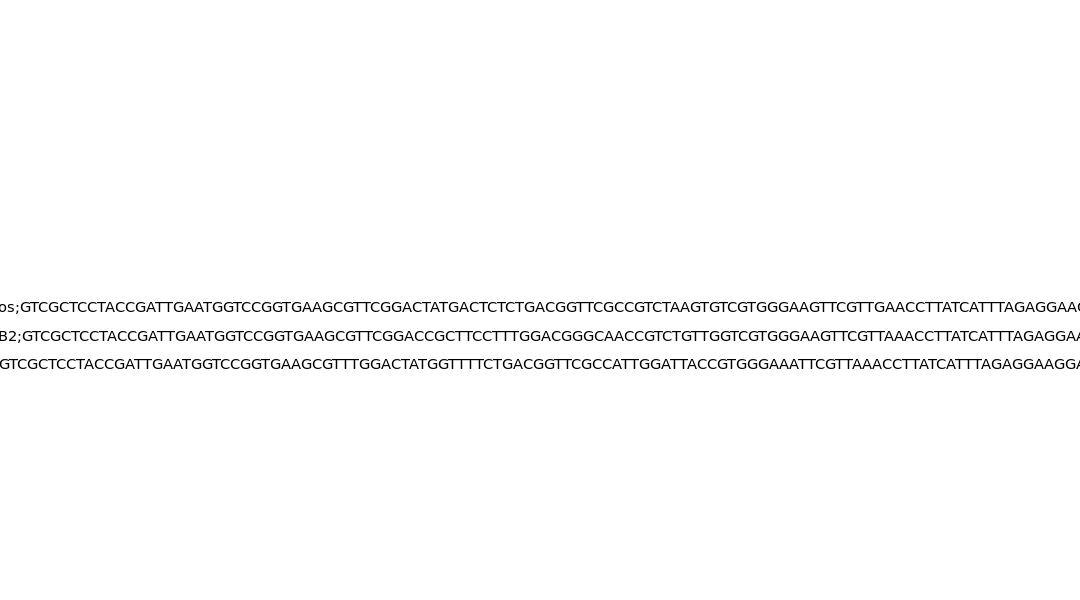

In [161]:
mag_example1 <- c("NAO-all-DCM-0-8-5-00_bin-131", "MS-all-DCM-0-8-5-00_bin-636", "SPO-all-DCM-0-8-5-00_bin-35")
plot_lm(mam_lm, mag_example1)

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.


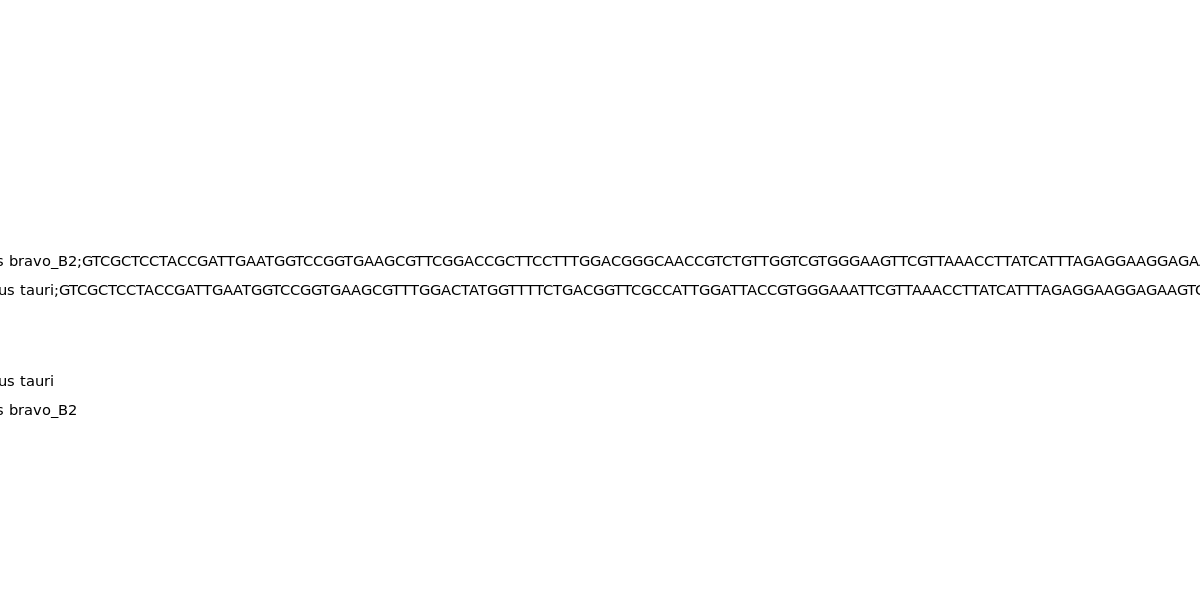

In [141]:
options(repr.plot.width = 10, repr.plot.height = 5)
mag_examples <- c("SPO-all-SRF-0-8-5-00_bin-551", "MS-all-DCM-0-8-5-00_bin-320", "SAO-all-DCM-0-8-5-00_bin-343")
plot_lm(mam_lm, mag_examples)

In [64]:
?geom_dl

In [109]:
# Dictyochophyceae   - order level
dict <- map_ASVtoMAG_bylevel(mag_relab, asv_relab, class, "Dictyochophyceae", class, 20)

In [111]:
dict_lm <- est_lm(dict, 20, 0.5)
head(dict_lm[1:2,])

tmp <- dict_lm %>% select(mag, seq, starts_with("fullname"), r.squared, OCCUR) %>% distinct()
dim(tmp)
write_delim(tmp, path = "dict_lm.txt", delim = "\t")

Warning message:
“All elements of `...` must be named.
Did you want `data = c(run_accession.MAG, relabun.MAG, sampleid, TAXA, supergroup.MAG, 
    division.MAG, class.MAG, order.MAG, family.MAG, genus.MAG, 
    species.MAG, fullname.MAG, run_accession.ASV, fullname.ASV, 
    supergroup.ASV, division.ASV, class.ASV, order.ASV, family.ASV, 
    genus.ASV, species.ASV, relabun.ASV, OCCUR)`?”Warning message:
“All elements of `...` must be named.
Did you want `data = c(run_accession.MAG, relabun.MAG, sampleid, TAXA, supergroup.MAG, 
    division.MAG, class.MAG, order.MAG, family.MAG, genus.MAG, 
    species.MAG, fullname.MAG, run_accession.ASV, fullname.ASV, 
    supergroup.ASV, division.ASV, class.ASV, order.ASV, family.ASV, 
    genus.ASV, species.ASV, relabun.ASV, OCCUR)`?”

0.506042919021986  min of r^2 values
0.885725706953743  max of r^2 values
4  total MAGs
9  total ASVs
17  total comparisons that will be plot


mag,seq,r.squared,Intercept,Slope,run_accession.MAG,relabun.MAG,sampleid,TAXA,supergroup.MAG,...,fullname.ASV,supergroup.ASV,division.ASV,class.ASV,order.ASV,family.ASV,genus.ASV,species.ASV,relabun.ASV,OCCUR
IO-all-SRF-0-8-5-00_bin-80,GTCGCACCTACCGATCGAAGGTAATGATGAGCCCTCAGGATGAGTTGACGCTGCCTTCACGGGCGGCACAGCTTAAAATTTGTGCAAATCCTTGCCTTTAGAGGAAGGTGAAGTCGTAACAAGGTTACC,0.6007218,0.0002876059,0.01059653,ERR599243,8.137083e-05,TARA_068_SRF_180-2000,Stramenopiles;Ochrophyta;Dictyochophyceae,Stramenopiles,...,Stramenopiles;Ochrophyta;Dictyochophyceae;Dictyochophyceae_X;Pedinellales;Pedinellales_X;Pedinellales_X sp.,Stramenopiles,Ochrophyta,Dictyochophyceae,Dictyochophyceae_X,Pedinellales,Pedinellales_X,Pedinellales_X sp.,0.001538904,43
IO-all-SRF-0-8-5-00_bin-80,GTCGCACCTACCGATCGAAGGTAATGATGAGCCCTCAGGATGAGTTGACGCTGCCTTCACGGGCGGCACAGCTTAAAATTTGTGCAAATCCTTGCCTTTAGAGGAAGGTGAAGTCGTAACAAGGTTACC,0.6007218,0.0002876059,0.01059653,ERR1726829,4.271433e-04,TARA_066_DCM_0.8-5,Stramenopiles;Ochrophyta;Dictyochophyceae,Stramenopiles,...,Stramenopiles;Ochrophyta;Dictyochophyceae;Dictyochophyceae_X;Pedinellales;Pedinellales_X;Pedinellales_X sp.,Stramenopiles,Ochrophyta,Dictyochophyceae,Dictyochophyceae_X,Pedinellales,Pedinellales_X,Pedinellales_X sp.,0.004917410,43


[1] 17  6

In [210]:
options(repr.plot.width = 18, repr.plot.height = 5.5)

# all <- as.character(unique(dict_lm$mag))
svg("dict_lm.svg", w = 18, h = 5.5)
# plot_lm(dict_lm, all)
# dev.off()
plot_lm(dict_lm, "MS-all-SRF-0-8-5-00_bin-588")
dev.off()

png 
  2

In [167]:
mag_relab %>% filter(class == "Chrysophyceae") %>% select(mag, fullname) %>% distinct()

mag,fullname
SAO-all-DCM-0-8-5-00_bin-428,Stramenopiles;Ochrophyta;Chrysophyceae
SPO-CHIL-SRF-0-8-5-00_bin-213,Stramenopiles;Ochrophyta;Chrysophyceae
NPO-all-SRF-0-8-5-00_bin-146,Stramenopiles;Ochrophyta;Chrysophyceae
MS-all-SRF-0-8-5-00_bin-542,Stramenopiles;Ochrophyta;Chrysophyceae
MS-all-SRF-0-8-5-00_bin-251,Stramenopiles;Ochrophyta;Chrysophyceae
SPO-all-SRF-0-8-5-00_bin-1028,Stramenopiles;Ochrophyta;Chrysophyceae
IO-all-SRF-0-8-5-00_bin-548,Stramenopiles;Ochrophyta;Chrysophyceae
SAO-all-SRF-0-8-5-00_bin-34,Stramenopiles;Ochrophyta;Chrysophyceae


In [169]:
# Dictyochophyceae   - order level
chrys <- map_ASVtoMAG_bylevel(mag_relab, asv_relab, class, "Chrysophyceae", class, 20)
chrys_lm <- est_lm(chrys, 20, 0.5)
head(chrys_lm[1:2,])

tmp <- chrys_lm %>% select(mag, seq, starts_with("fullname"), r.squared, OCCUR) %>% distinct()
dim(tmp)
write_delim(tmp, path = "chrys_lm.txt", delim = "\t")

Warning message:
“All elements of `...` must be named.
Did you want `data = c(run_accession.MAG, relabun.MAG, sampleid, TAXA, supergroup.MAG, 
    division.MAG, class.MAG, order.MAG, family.MAG, genus.MAG, 
    species.MAG, fullname.MAG, run_accession.ASV, fullname.ASV, 
    supergroup.ASV, division.ASV, class.ASV, order.ASV, family.ASV, 
    genus.ASV, species.ASV, relabun.ASV, OCCUR)`?”Warning message:
“All elements of `...` must be named.
Did you want `data = c(run_accession.MAG, relabun.MAG, sampleid, TAXA, supergroup.MAG, 
    division.MAG, class.MAG, order.MAG, family.MAG, genus.MAG, 
    species.MAG, fullname.MAG, run_accession.ASV, fullname.ASV, 
    supergroup.ASV, division.ASV, class.ASV, order.ASV, family.ASV, 
    genus.ASV, species.ASV, relabun.ASV, OCCUR)`?”

0.510816545468671  min of r^2 values
0.966600864655771  max of r^2 values
8  total MAGs
11  total ASVs
38  total comparisons that will be plot


mag,seq,r.squared,Intercept,Slope,run_accession.MAG,relabun.MAG,sampleid,TAXA,supergroup.MAG,...,fullname.ASV,supergroup.ASV,division.ASV,class.ASV,order.ASV,family.ASV,genus.ASV,species.ASV,relabun.ASV,OCCUR
SAO-all-DCM-0-8-5-00_bin-428,GTCGCACCTACCGATTGAATGTCTCGGTGAAATCCCCGGACTATCGCTTAGAGACCCTCGGGTCCCTTCGCAGTGGGAAGCGGATTAAACCTCGATATTTAGAGGAAGGTGAAGTCGTAACAAGGTCTCC,0.5582446,0.000767612,0.02078699,ERR1726574,0.0002824946,TARA_026_SRF_180-2000,Stramenopiles;Ochrophyta;Chrysophyceae,Stramenopiles,...,Stramenopiles;Ochrophyta;Chrysophyceae;Chrysophyceae_X,Stramenopiles,Ochrophyta,Chrysophyceae,Chrysophyceae_X,NA,NA,NA,0.0003547038,32
SAO-all-DCM-0-8-5-00_bin-428,GTCGCACCTACCGATTGAATGTCTCGGTGAAATCCCCGGACTATCGCTTAGAGACCCTCGGGTCCCTTCGCAGTGGGAAGCGGATTAAACCTCGATATTTAGAGGAAGGTGAAGTCGTAACAAGGTCTCC,0.5582446,0.000767612,0.02078699,ERR1726868,0.0006374798,TARA_038_DCM_180-2000,Stramenopiles;Ochrophyta;Chrysophyceae,Stramenopiles,...,Stramenopiles;Ochrophyta;Chrysophyceae;Chrysophyceae_X,Stramenopiles,Ochrophyta,Chrysophyceae,Chrysophyceae_X,NA,NA,NA,0.0004352014,32


[1] 38  6

In [171]:
options(repr.plot.width = 20, repr.plot.height = 6)

all <- as.character(unique(chrys_lm$mag))
svg("chrys_lm.svg", w = 20, h = 8)
plot_lm(chrys_lm, all)
dev.off()

png 
  2

In [175]:
options(repr.plot.width = 20, repr.plot.height = 7)
svg("chrys_magexample.svg", w = 20, h = 7)
plot_lm(chrys_lm, "IO-all-SRF-0-8-5-00_bin-548")
dev.off()

png 
  2

In [ ]:
## Run above function together. Outputs stats about how many plots would be created in next step
ostreo <- map_ASVtoMAG_bylevel(mag_relab, asv_relab, genus, "Ostreococcus", 15)
ostreo_lm <- lm_generate(ostreo, 0.5)
head(ostreo_lm[1:3,])
bestfit_lm(ostreo_lm, 50, "Ostreococcus-bestfit.txt")

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 12)
plot_lm_results(ostreo_lm, "Ostreococcus")
# plot_lm_results(filter(ostreo_lm, mag == "NAO-all-DCM-0-8-5-00_bin-171"), "Ostreococcus")

In [ ]:
dictyo <- map_ASVtoMAG_bylevel(mag_relab, asv_relab, order, "Dictyochophyceae_X", 10)
dictyo_lm <- lm_generate(dictyo, 0.5)

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 18) #set plot size output 
plot_lm_results(dictyo_lm, "Dictyochophyceae")

In [ ]:
prym <- map_ASVtoMAG_bylevel(mag_relab, asv_relab, order, "Prymnesiales", 10)
prym_lm <- lm_generate(prym, 0.5)

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 18)
plot_lm_results(prym_lm, "Prymnesiales")

In [ ]:
# Calculate bestfir for Chlorophyta division
chloro <- map_ASVtoMAG_bylevel(mag_relab, asv_relab, division, "Chlorophyta", 50)
chloro_lm <-lm_generate(chloro, 0.6)
bestfit_lm(chloro_lm, 75, "Chlorophyta-bestfit.txt")

# Calculate bestfir for Haptophyta division
hap <- map_ASVtoMAG_bylevel(mag_relab, asv_relab, division, "Haptophyta", 50)
hap_lm <-lm_generate(hap, 0.6)
bestfit_lm(hap_lm, 75, "Haptophyta-bestfit.txt")

# Calculate bestfir for Cryptophyta division
crypt <- map_ASVtoMAG_bylevel(mag_relab, asv_relab, division, "Cryptophyta", 50)
hap_lm <-lm_generate(hap, 0.6)
bestfit_lm(hap_lm, 75, "Cryptophyta-bestfit.txt")

## Working versions to run function in parallel

In [ ]:
library(multidplyr)

In [48]:
library(parallel)
detectCores()

[1] 36

In [84]:
#
# Partition data
#
# library(parallel); library(tidyverse); library(multidplyr)
#
#
map_ASVtoMAG_party <- function(mag_df, asv_df, level, freq){
    level <- enquo(level)
    cluster <- new_cluster(detectCores()[1])
    writeLines(paste("Using", detectCores()[1], "cores"))
     # Generate TAXA column to group input data, partition to run on cluster
    out <- mag_df %>% 
    unite(TAXA, supergroup:!!level, remove = TRUE, sep =";") %>% 
    group_by(TAXA) %>% 
    filter(!is.na(run_accession)) %>% 
    data.frame
    taxa_grab <- as.character(unique(out$TAXA))
    for(a in taxa_grab){
        tmp <- out %>% filter(TAXA == i) %>%
            left_join(unite(asv_df, TAXA, supergroup:!!level, remove = TRUE, sep =";"), 
              by = c("TAXA"="TAXA", "sampleid" = "sampleid"), suffix = c(".MAG", ".ASV")) %>% 
        group_by(mag, seq) %>% 
        mutate(OCCUR = n()) %>% 
        filter(OCCUR > freq) %>% 
        data.frame
        name <- paste("df_joined", a)
    }
#     partition(cluster)
#     # Columns that are repeated from each data will be affixed with .MAG or .ASV
#     out2 <- left_join(out, unite(asv_df, TAXA, supergroup:!!level, remove = TRUE, sep =";"), 
#               by = c("TAXA"="TAXA", "sampleid" = "sampleid"), suffix = c(".MAG", ".ASV")) %>%
#     group_by(mag, seq) %>% 
#     mutate(OCCUR = n()) %>% # Count occurences of matching for each mag-seq pair (number of Tara ocean samples that have both an ASV and MAG that we can compare)
#     filter(OCCUR > freq)
#     return(out2)
    }

In [85]:
# tmp_part <- map_ASVtoMAG_party(mag_relab, asv_relab, order, 50)
tmp_part <- map_ASVtoMAG_party(mag_sub, asv_sub, order, 50)

Using 36 cores
done with Archaeplastida;Chlorophyta;Mamiellophyceae;Mamiellales


EXCESS

In [11]:
#     do({lm.fit = lm(relabun.MAG ~ relabun.ASV, data = .)
#         data.frame(tidy(lm.fit), glance(lm.fit))}) %>% 
#     select(mag, seq, r.squared, p.value, term, estimate) %>% 
#     spread(term, estimate) %>% 
#     select(everything(), -`(Intercept)`, slope = relabun.ASV) %>% 
#     # Remove negative slope
#     filter(slope > 0) %>% 
#     # For each mag, select highest r.squared value
#     group_by(mag) %>%
#     arrange(desc(r.squared)) %>% 
#     slice(1) %>% 
    #
#     # Add in sample information associated with all instances
#     # Add in original mag-desigated taxa, sample info and relative abundance
#     right_join(select(mag_df, mag, sampleid, fullname, relabun), by = c("mag" = "mag")) %>% 
#     # Add in original asv-designated taxa information, sample info, and relative abundance
#     left_join(select(asv_df, seq, sampleid, fullname, relabun), by = c("seq" = "seq", "sampleid" = "sampleid"), suffix = c(".MAG", ".ASV")) %>% 
#     filter(!is.na(fullname.ASV) & !is.na(sampleid)) %>% 
    #
  ### Add in full taxonomic IDs to compare original MAG and ASV designations
    # Add in original mag-desigated taxa
#     right_join(select(mag_df, mag, fullname) %>% distinct(), by = c("mag" = "mag")) %>% 
#     # Add in original asv-designated taxa information
#     left_join(select(asv_df, seq, fullname) %>% distinct(), by = c("seq" = "seq"), suffix = c(".MAG", ".ASV"))  %>% 
#     data.frame
# #     write_delim(out, path = filename, delim = "\t")
#     }
# # write_delim(map_ASVtoMAG_runlm(mag_relab, asv_relab, class, 50), path = "bestfit-27-07-2020.txt", delim = "\t")
# Keep: mag or seq, sampleid, fullname, relabun

In [189]:
unique(mag_relab$order)

[1] <NA>                  Bacillariophyta_X     -                    
 [4] Mamiellales           Prasinococcales       Chloropicales        
 [7] Dictyochophyceae_X    Prymnesiales          Cryptomonadales      
[10] Parmales              Pseudoscourfieldiales Pelagomonadales      
[13] Saccharomycotina     
12 Levels: - Bacillariophyta_X Chloropicales ... Saccharomycotina

In [199]:
# # Base information on the taxonomic naming of the MAGs
# # head(mag_relab)
# mag_plot <- mag_relab %>% 
#     filter(!is.na(supergroup)) %>% 
#     unite(CLASS, supergroup, division, class, sep = ";", remove = FALSE) %>% 
#     group_by(CLASS) %>% 
#     mutate(CLASS_SUM = sum(relabun)) %>% 
#     mutate(ORDER = case_when(
#         order == "-" ~ 0,
#         TRUE ~ 0),
#           FAMILY = case_when(
#           family == "-" ~ 0,
#           TRUE ~ 1)) %>% 
#     select(CLASS, CLASS_SUM, ORDER, FAMILY) %>%
#     pivot_longer(CLASS_SUM:FAMILY) %>% 
#     group_by(CLASS, name) %>% 
#     summarise(SUM = sum(value)) %>% 
#     data.frame
# head(mag_plot)
# str(mag_plot)

`summarise()` regrouping output by 'CLASS' (override with `.groups` argument)


CLASS,name,SUM
Archaeplastida;Chlorophyta;-,CLASS_SUM,647467.5
Archaeplastida;Chlorophyta;-,FAMILY,0.0
Archaeplastida;Chlorophyta;-,ORDER,0.0
Archaeplastida;Chlorophyta;Chloropicophyceae,CLASS_SUM,2535251.9
Archaeplastida;Chlorophyta;Chloropicophyceae,FAMILY,26222.0
Archaeplastida;Chlorophyta;Chloropicophyceae,ORDER,0.0


'data.frame':	45 obs. of  3 variables:
 $ CLASS: chr  "Archaeplastida;Chlorophyta;-" "Archaeplastida;Chlorophyta;-" "Archaeplastida;Chlorophyta;-" "Archaeplastida;Chlorophyta;Chloropicophyceae" ...
 $ name : chr  "CLASS_SUM" "FAMILY" "ORDER" "CLASS_SUM" ...
 $ SUM  : num  647468 0 0 2535252 26222 ...


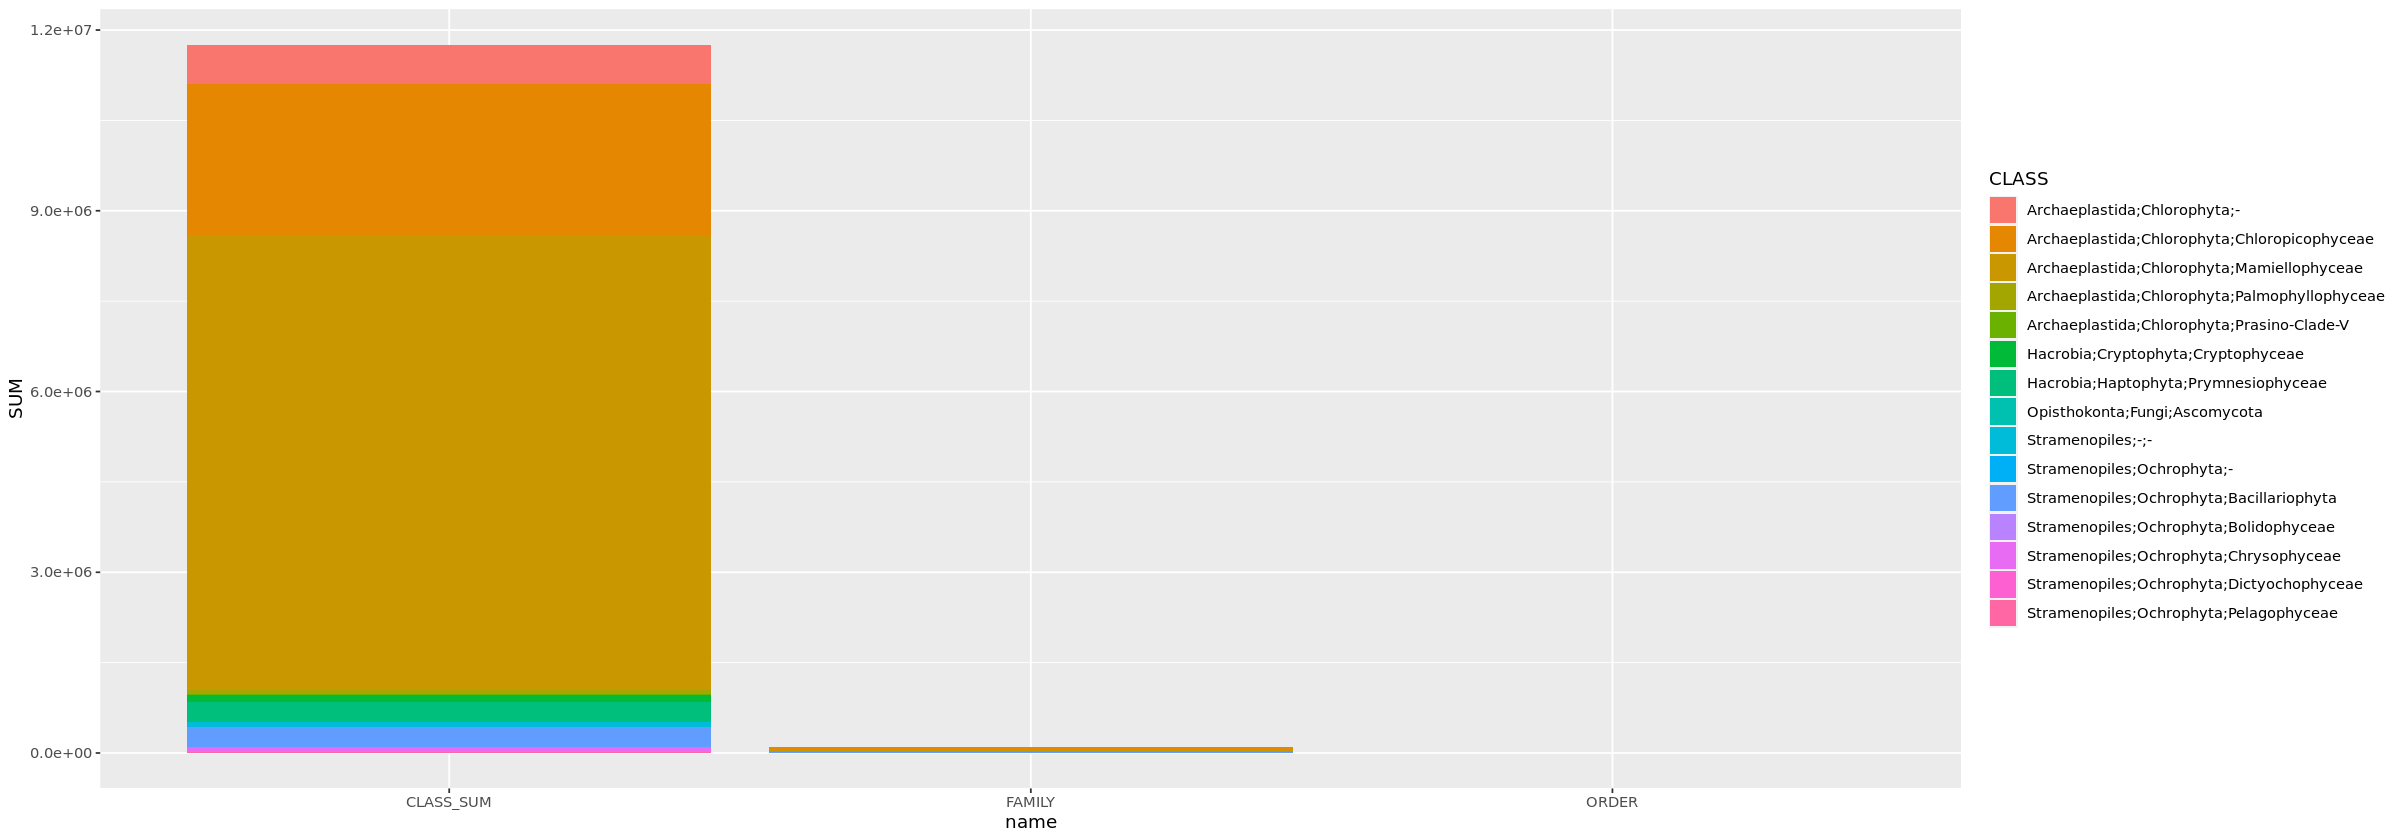

In [201]:
ggplot(mag_plot, aes(x = name, y = SUM, fill = CLASS)) +
    geom_bar(stat = "identity", position = "stack")

In [ ]:
# # # FXN - perform linear regression
# lm_best_fit <- function(df, r){
#     df_final <- df %>% 
#     group_by(mag, seq) %>% 
#     do({lm.fit = lm(relabun.MAG ~ relabun.ASV, data = .)
#        data.frame(tidy(lm.fit), glance(lm.fit))}) %>% 
#     select(mag, seq, r.squared, p.value, term, estimate) %>% 
#     spread(term, estimate) %>% 
#     select(everything(), -`(Intercept)`, slope = relabun.ASV) %>% 
#     filter(slope > 0) %>% 
#     filter(r.squared > r) %>% 
#     #

    
#     data.frame
#     tmp_stats <- df_final %>% 
#     select(mag, seq, OCCUR, r.squared, p.value) %>% 
#     distinct()
#     # Report:
#     writeLines(paste(range(tmp_stats$r.squared)[1], " min of r^2 values"))
#     writeLines(paste(range(tmp_stats$r.squared)[2], " max of r^2 values"))
#     writeLines(paste(length(unique(tmp_stats$mag))," total MAGs"))
#     writeLines(paste(length(unique(tmp_stats$seq))," total ASVs"))
#     writeLines(paste(dim(tmp_stats)[1]," total comparisons that will be plot"))
#     return(df_final)
#     }



# # Perform linear regression - select r^2 value to filter by
# find_bestfit_r2 <- function(df, r){
#     df %>% 
#     nest(-mag, -seq) %>% 
#     mutate(lm_fit = map(data, ~ lm(relabun.MAG ~ relabun.ASV, data = .)),
#           results = map(lm_fit, glance)) %>% 
#     unnest(results) %>% 
#     select(mag, seq, r.squared, p.value) %>% 
#     right_join(df, by = c("mag"="mag", "seq"="seq"))  %>% 
#     filter(r.squared > r) %>% 
#     data.frame
#     }
#
# select best R2 and highest occur
# # Run for everything, class and order
# find_bestfit_rank <- function(df, number){
#     df %>% 
#     group_by(mag, seq) %>% 
#     filter(slope > 0) %>% # Select non-negative slopes
#     arrange(desc(r.squared)) %>% # NEED TO GET HIGHEST OCCURENCES
#     top_n(number) %>% 
#     ungroup() %>% 
#     select(mag, seq, MAG_taxa = fullname.MAG, ASV_taxa = fullname.ASV, r.squared) %>% 
#     distinct() %>% 
#     data.frame
#     }
# How many unique ASV-MAG pairs will be compared?
# check_stats_lm <- function(df) {
#     tmp_stats <- df %>% 
#     select(mag, seq, OCCUR, r.squared, p.value) %>% 
#     distinct()
#     # Report:
#     writeLines(paste(range(tmp_stats$r.squared)[1], " min of r^2 values"))
#     writeLines(paste(range(tmp_stats$r.squared)[2], " max of r^2 values"))
#     writeLines(paste(length(unique(tmp_stats$mag))," total MAGs"))
#     writeLines(paste(length(unique(tmp_stats$seq))," total ASVs"))
#     writeLines(paste(dim(tmp_stats)[1]," total comparisons that will be plot"))
#     }